# EQUITY AMERICAN OPTION - BAW APPROXIMATION

Valuation and Risk of American-style options on equity using BAW approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.market.curves.FinDiscountCurveFlat import *
from financepy.products.equity import *
from financepy.models.FinModelBlackScholes import *

####################################################################
# FINANCEPY BETA Version 0.191 - This build:  17 Jan 2021 at 21:17 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



# Define the Call and Put Options

In [3]:
valuation_date = Date(8, 5, 2015)

In [4]:
expiry_date = Date(15, 1, 2016)

In [5]:
strike_price = 130

Create the call Option

In [6]:
amCallOption = EquityAmericanOption(expiry_date, strike_price, FinOptionTypes.AMERICAN_CALL)

In [7]:
print(amCallOption)

OBJECT TYPE: EquityAmericanOption
EXPIRY DATE: 15-JAN-2016
STRIKE PRICE: 130
OPTION TYPE: FinOptionTypes.AMERICAN_CALL
NUMBER: 1.0


We can also define an American option with a European payoff - this way we will use the same CRR tree for the pricing.

In [8]:
euCallOption = EquityAmericanOption(expiry_date, strike_price, FinOptionTypes.EUROPEAN_CALL)

We can also define an actual vanilla call option which will be priced using Black Scholes.

In [9]:
call_option = EquityVanillaOption(expiry_date, strike_price, FinOptionTypes.EUROPEAN_CALL)

Now we can explore the pricing of all three to check for consistency and tree convergence.

## Valuation

In [16]:
stock_price = 127.62
volatility = 0.20
interest_rate = 0.001
dividend_yield = 0.0163

In [17]:
discount_curve = FinDiscountCurveFlat(valuation_date, interest_rate,
                                     FrequencyTypes.CONTINUOUS, 
                                     DayCountTypes.ACT_365F)

In [18]:
dividend_curve = FinDiscountCurveFlat(valuation_date, dividend_yield)

We now define the model. This is Black-Scholes. We can also specify the number of steps to use on the tree,

In [19]:
num_steps_per_year = 400

In [20]:
modelTree = FinModelBlackScholes(volatility, 
                                 FinModelBlackScholesTypes.CRR_TREE, 
                                 {'num_steps_per_year':num_steps_per_year} )

In [21]:
amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)

6.8391380697921615

In [22]:
modelApprox = FinModelBlackScholes(volatility, FinModelBlackScholesTypes.BARONE_ADESI)

In [23]:
amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelApprox)

6.827753597158052

Compare it to European using same tree

In [24]:
euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)

6.751136062156512

This is lower as we would expect due to the lack of early exercise. Let's check this against the Black Scholes model analytical form.

In [25]:
modelAnal = FinModelBlackScholes(volatility, FinModelBlackScholesTypes.ANALYTICAL)

In [26]:
call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, modelAnal)

6.749356623876585

The price is close to the 6.74927 found by QL - see http://gouthamanbalaraman.com/blog/european-option-binomial-tree-quantlib-python.html. Differences with QL could be due to differences in time calculations. It is also different from the Tree value but that is a tree convergence issue. Let's see how good convergence is.

## Tree Convergence

In [27]:
num_steps_per_year = range(5, 200, 1)

In [28]:
amTreeValue = []
amBAWValue = []
euTreeValue = []
euAnalValue = []

volatility = 0.20

for num_steps in num_steps_per_year:

    modelTree = FinModelBlackScholes(volatility,
                                     FinModelBlackScholesTypes.CRR_TREE,
                                     {'num_steps_per_year':num_steps})

    modelAnal = FinModelBlackScholes(volatility, 
                                     FinModelBlackScholesTypes.ANALYTICAL)

    modelBAW = FinModelBlackScholes(volatility, 
                                    FinModelBlackScholesTypes.BARONE_ADESI)

    v_am = amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)
    v_eu = euCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelTree)
    v_bs = call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, modelAnal)
    v_am_baw = amCallOption.value(valuation_date, stock_price, discount_curve, dividend_curve, modelBAW)

    amTreeValue.append(v_am)
    euTreeValue.append(v_eu)
    euAnalValue.append(v_bs)
    amBAWValue.append(v_am_baw)


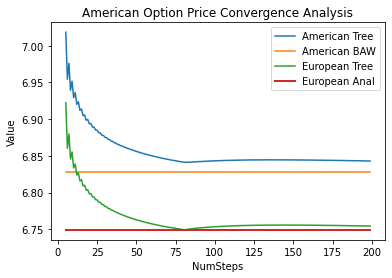

In [37]:
plt.title("American Option Price Convergence Analysis")
plt.plot(num_steps_per_year, amTreeValue, label="American Tree")
plt.plot(num_steps_per_year, amBAWValue, label="American BAW")
plt.plot(num_steps_per_year, euTreeValue, label="European Tree")
plt.plot(num_steps_per_year, euAnalValue, label="European Anal", lw =2)
plt.xlabel("NumSteps")
plt.ylabel("Value")
plt.legend();

Agreement with QL is very good and tree convergence appears much better - probably assisted by fact that I average even and odd numbers of steps internally.

Copyright (c) 2020 Dominic O'Kane